In [2]:
import argparse
import time
import os
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from meta_ood.meta_ood_master.config import config_evaluation_setup
from meta_ood.meta_ood_master.src.imageaugmentations import Compose, Normalize, ToTensor
from meta_ood.meta_ood_master.src.model_utils import probs_gt_load
from meta_ood.meta_ood_master.src.helper import metrics_dump, components_dump, concatenate_metrics, metrics_to_dataset, components_load
from meta_ood.meta_ood_master.src.model_utils import inference
from multiprocessing import Pool, cpu_count
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression

In [3]:
try:
    from meta_ood.meta_ood_master.src.metaseg.metrics import compute_metrics_components, compute_metrics_mask
except ImportError:
    compute_metrics_components, compute_metrics_mask = None, None
    print("MetaSeg ImportError: Maybe need to compile (src/metaseg/)metrics.pyx ....")
    exit()

In [4]:
class meta_classification(object):
    """
    Perform meta classification with the aid of logistic regressions in order to remove false positive OoD predictions
    """
    def __init__(self, params, roots, dataset=None, num_imgs=None, metaseg_dir=None):
        self.epoch = params.val_epoch
        self.alpha = params.pareto_alpha
        self.thresh = params.entropy_threshold
        self.dataset = dataset
        self.net = roots.model_name
        if self.epoch == 0:
            self.load_subdir = "baseline" + "_t" + str(self.thresh)
        else:
            self.load_subdir = "epoch_" + str(self.epoch) + "_alpha_" + str(self.alpha) + "_t" + str(self.thresh)
        if metaseg_dir is None:
            self.metaseg_dir = os.path.join(roots.io_root, "metaseg_io")
        else:
            self.metaseg_dir = metaseg_dir
        self.num_imgs = len(self.dataset) if num_imgs is None else num_imgs

    def classifier_fit_and_predict(self):
        """Fit a logistic regression and cross validate performance"""
        print("\nClassifier fit and predict")
        metrics, start = concatenate_metrics(metaseg_root=self.metaseg_dir, subdir=self.load_subdir,
                                             num_imgs=self.num_imgs)
        Xa, _, _, y0a, X_names, class_names = metrics_to_dataset(metrics, self.dataset.num_eval_classes)
        y_pred_proba = np.zeros((len(y0a), 2))

        model = LogisticRegression(solver="liblinear")
        loo = LeaveOneOut()

        for train_index, test_index in loo.split(Xa):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = Xa[train_index], Xa[test_index]
            y_train, y_test = y0a[train_index], y0a[test_index]
            model.fit(X_train, y_train)
            y_pred_proba[test_index] = model.predict_proba(X_test)

        auroc = roc_auc_score(y0a, y_pred_proba[:, 1])
        auprc = average_precision_score(y0a, y_pred_proba[:, 1])
        y_pred = np.argmax(y_pred_proba, axis=-1)
        acc = accuracy_score(y0a, y_pred)
        print("\nMeta classifier performance scores:")
        print("AUROC:", auroc)
        print("AUPRC:", auprc)
        print("Accuracy:", acc)

        metrics["kick"] = y_pred
        metrics["start"] = start
        metrics["auroc"] = auroc
        metrics["auprc"] = auprc
        metrics["acc"] = acc

        save_path = os.path.join(self.metaseg_dir, "metrics", self.load_subdir, "meta_classified.p")
        with open(save_path, 'wb') as f:
            pickle.dump(metrics, f, pickle.HIGHEST_PROTOCOL)
            print("Saved meta classified:", save_path)
        return metrics, start

    def remove(self):
        """Based on a meta classifier's decision, remove false positive predictions"""
        print("\nRemoving False positive OoD segment predictions")
        load_path = os.path.join(self.metaseg_dir, "metrics", self.load_subdir, "meta_classified.p")
        if os.path.isfile(load_path):
            with open(load_path, "rb") as metrics_file:
                metrics = pickle.load(metrics_file)
                K = metrics["kick"]
                start = metrics["start"]
        else:
            metrics, start = self.classifier_fit_and_predict()
            K = metrics["kick"]
        fn_after = 0
        for i in range(len(start) - 1):
            comp_pred = abs(components_load(i, self.metaseg_dir, self.load_subdir)).flatten()
            for l, k in enumerate(K[start[i]:start[i + 1]]):
                if k == 1:
                    comp_pred[comp_pred == l + 1] = 0
            comp_pred[comp_pred > 0] = 1
            comp_gt = abs(components_load(i, self.metaseg_dir, self.load_subdir + "_gt")).flatten()
            for c in np.unique(comp_gt)[1:]:
                comp_c = np.squeeze([comp_gt == c])
                if np.sum(comp_c[comp_pred > 0]) == 0:
                    fn_after += 1
            print("\rImages Processed: %d,  Num FNs: %d" % (i + 1, fn_after), end=' ')
            sys.stdout.flush()
        fp_before = len([i for i in range(len(metrics["iou"])) if metrics["iou"][i] == 0])
        fp_after = np.sum([metrics["kick"] == 1]) - np.sum(np.array(metrics["iou0"])[metrics["kick"] == 1])
        return fn_after, fp_before, fp_after

In [7]:
def metaseg_prepare(params, roots, dataset):
    """Generate Metaseg input which are .hdf5 files"""
    inf = inference(params, roots, dataset, dataset.num_eval_classes)
    for i in range(len(dataset)):
        inf.probs_gt_save(i)


def entropy_segments_mask(probs, t):
    """Generate OoD prediction mask from softmax probabilities"""
    ent = entropy(probs) / np.log(probs.shape[0])
    print(ent.shape)
    ent[ent < t] = 0
    ent[ent >= t] = 1
    return ent.astype("uint8")


class compute_metrics(object):
    """
    Compute the hand-crafted segment-wise metrics serving as meta classification input
    """
    def __init__(self, params, roots, dataset, num_imgs=None, metaseg_dir=None, num_cores=1):
        self.epoch = params.val_epoch
        self.alpha = params.pareto_alpha
        self.thresh = params.entropy_threshold
        self.dataset = dataset
        if self.epoch == 0:
            print("Load directory: {}".format(os.path.join(roots.io_root, "probs/baseline")))
            self.load_dir = os.path.join(roots.io_root, "probs/baseline")
            self.save_subdir = "baseline" + "_t" + str(self.thresh)
            
        else:
            self.load_dir = os.path.join(roots.io_root, "probs/epoch_" + str(self.epoch) + "_alpha_" + str(self.alpha))
            self.save_subdir = "epoch_" + str(self.epoch) + "_alpha_" + str(self.alpha) + "_t" + str(self.thresh)
        self.num_imgs = len(dataset) if num_imgs is None else num_imgs
        if metaseg_dir is None:
            self.metaseg_dir = os.path.join(roots.io_root, "metaseg_io")
        else:
            self.metaseg_dir = metaseg_dir
        self.num_cores = num_cores

    def compute_metrics_per_image(self, num_cores=None):
        """Perform segment search and compute corresponding segment-wise metrics"""
        print("Calculating statistics for", self.save_subdir)
        if num_cores is None:
            num_cores = self.num_cores
        p_args = [(k,) for k in range(self.num_imgs)] #k,... create tuple with single element
        print("p_args = {}".format(p_args))
        Pool(num_cores).starmap(self.compute_metrics_pred_i, p_args)
        Pool(num_cores).starmap(self.compute_metrics_gt_i, p_args)

    def compute_metrics_pred_i(self, i):
        """Compute metrics for predicted segments in one image"""
        start_i = time.time()
        probs, gt_train, _, img_path = probs_gt_load(i, load_dir=self.load_dir) #returns softmax probabilites, gt_train_ids as numpy arrays and the image path
        ent_mask = entropy_segments_mask(probs, self.thresh) #creates the entropy mask where everything above threshold is 1 and below 0 from softmax probabilities
        # print("probs.shape = {}, type(probs) = {}\n".format(probs.shape, type(probs)))
        # print("gt_train.shape = {}, type(gt_train) = {}\n".format(gt_train.shape, type(gt_train)))
        # print("ent_mask.shape = {}, type(ent_mask) = {}\n".format(ent_mask.shape, type(ent_mask)))
        metrics, components = compute_metrics_components(probs=probs, gt_train=gt_train, ood_mask=ent_mask,
                                                         ood_index=self.dataset.train_id_out)
        metrics_dump(metrics, i, metaseg_root=self.metaseg_dir, subdir=self.save_subdir)
        components_dump(components, i, metaseg_root=self.metaseg_dir, subdir=self.save_subdir)
        print("image", i, "processed in {}s\n".format(round(time.time() - start_i)))

    def compute_metrics_gt_i(self, i):
        """Compute metrics for ground truth segments in one image"""
        start_i = time.time()
        probs, gt_train, gt_label, img_path = probs_gt_load(i, load_dir=self.load_dir)
        ent_mask = entropy_segments_mask(probs, self.thresh)
        metrics, components = compute_metrics_mask(probs=probs, mask=ent_mask, gt_train=gt_train, gt_label=gt_label,
                                                   ood_index=self.dataset.train_id_out)
        metrics_dump(metrics, i, metaseg_root=self.metaseg_dir, subdir=self.save_subdir + "_gt")
        components_dump(components, i, metaseg_root=self.metaseg_dir, subdir=self.save_subdir + "_gt")
        print("image", i, "processed in {}s\n".format(round(time.time() - start_i)))
    
args={"VALSET": "Fishyscapes", #or LostAndFound
      "MODEL": "UNetResNet",#DeepLabV3+_WideResNet38
      "val_epoch": 76,
      "pareto_alpha": 0.9,
      "entropy_threshold":0.8,
      "metaseg_prepare": True,
      "segment_search":False,
      "fp_removal": False}

config = config_evaluation_setup(args)

transform = Compose([ToTensor(), Normalize(config.dataset.mean, config.dataset.std)])
datloader = config.dataset(root=config.roots.eval_dataset_root, split="Static", transform=transform)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Operating on {}.".format(device))
start = time.time()

"""Perform Meta Classification"""
if not args["metaseg_prepare"] and not args["segment_search"] and not args["fp_removal"]: #if they all false, set them to true
    args["metaseg_prepare"] = args["segment_search"] = args["fp_removal"] = True
if args["metaseg_prepare"]: 
    print("PREPARE METASEG INPUT")
    metaseg_prepare(config.params, config.roots, datloader) #prepare Model for specified training epoch
if args["segment_search"]:
    print("SEGMENT SEARCH")
    compute_metrics(config.params, config.roots, datloader, num_cores=cpu_count() - 2).compute_metrics_per_image()
if args["fp_removal"]:
    print("FALSE POSITIVE REMOVAL VIA META CLASSIFICATION")
    meta_classification(config.params, config.roots, datloader).classifier_fit_and_predict()

end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nFINISHED {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

Operating on cuda.
PREPARE METASEG INPUT
UNetResNet
Checkpoint file: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/../weights/UNetResNet_epoch_76_alpha_0.9.pth
Load model: UNetResNet

/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


... ok
Create directory: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/probs/epoch_76_alpha_0.9
file stored: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/probs/epoch_76_alpha_0.9/probs0.hdf5
file stored: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/probs/epoch_76_alpha_0.9/probs1.hdf5
file stored: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/probs/epoch_76_alpha_0.9/probs2.hdf5
file stored: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/probs/epoch_76_alpha_0.9/probs3.hdf5
file stored: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/probs/epoch_76_alpha_0.9/probs4.hdf5
file stored: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/fs_eval/p

In [4]:
#helpers for explanation
def entropy_segments_mask(ent, t):
    """Generate OoD prediction mask from softmax probabilities"""
    # print(probs.shape)
    # ent = entropy(probs) / np.log(probs.shape[0])
    # print(ent.shape)
    ent[ent < t] = 0
    ent[ent >= t] = 1
    return ent.astype("uint8")

In [5]:
#To see how it works
test = np.array([[0.1, 0.3, 0.4],
                 [0.8, 0.2, 0.7],
                 [0.1, 0.3, 0.9]])
test = np.repeat(test[np.newaxis, :, :], 3, axis=0)
test[0, :, 2] = 0.15
test[0, :, 1] = 0.3
test[0, :, 0] = 0.1
test[1, :, 2] = 0.7
test[1, :, 1] = 0.3
test[1, :, 0] = 0.1
test[2, :, 2] = 0.15
test[2, :, 1] = 0.4
test[2, :, 0] = 0.8
print("0. In this example, the output consists of three classes with follwing probabilities: \n{}\n".format(test))

ent = entropy(test) / np.log(test.shape[0])
print("1. Calculate the image pixel wise softmax entropy: \n{}\n".format(ent))

ent_mask=entropy_segments_mask(ent,0.7)
print("2. We create the entropy mask of the pixel wise entropy according to the threshold 0.7: \n{}\n".format(ent_mask))

target_test=np.array([[0, 1, 1],
                      [0, 1, 1],
                      [1, 1, 0]])
print("3. The target has the following classes:\n0... road\n1... anomaly\n255... unlabled\n{}\n".format(target_test))



0. In this example, the output consists of three classes with follwing probabilities: 
[[[0.1  0.3  0.15]
  [0.1  0.3  0.15]
  [0.1  0.3  0.15]]

 [[0.1  0.3  0.7 ]
  [0.1  0.3  0.7 ]
  [0.1  0.3  0.7 ]]

 [[0.8  0.4  0.15]
  [0.8  0.4  0.15]
  [0.8  0.4  0.15]]]

1. Calculate the image pixel wise softmax entropy: 
[[0.58167187 0.99115947 0.74531158]
 [0.58167187 0.99115947 0.74531158]
 [0.58167187 0.99115947 0.74531158]]

2. We create the entropy mask of the pixel wise entropy according to the threshold 0.7: 
[[0 1 1]
 [0 1 1]
 [0 1 1]]

3. The target has the following classes:
0... road
1... anomaly
255... unlabled
[[0 1 1]
 [0 1 1]
 [1 1 0]]



In [6]:
def prediction(probs, gt=None, ignore=False ):
    pred = np.asarray( np.argmax( probs, axis=-1 ), dtype="uint8" )
    if ignore and gt is not None:
        pred[ gt==255 ] = 255
    return pred
pred= np.asarray( prediction(test, gt=target_test, ignore=False), dtype="uint8" )
print("5. The prediction shows the argmax for each row in the softmax tensor:\n {}".format(pred))

5. The prediction shows the argmax for each row in the softmax tensor:
 [[1 1 1]
 [2 2 2]
 [0 0 0]]


In [16]:
# from meta_ood.meta_ood_master.src.metaseg.metrics import segment_search
def entropy( probs ):
    E = np.sum( np.multiply( probs, np.log(probs+np.finfo(np.float32).eps) ) , axis=-1) / np.log(1.0/probs.shape[-1])
    return np.asarray( E, dtype="float32" )



def probdist( probs ):
    arrayA = np.asarray(np.argsort(probs,axis=-1), dtype="uint8")
    arrayD= np.ones( probs.shape[:-1], dtype="float32" )
    P = probs
    D = arrayD
    A = arrayA
    for i in range( arrayD.shape[0] ):
        for j in range( arrayD.shape[1] ):
            D[i,j] = ( 1 - P[ i, j, A[i,j,-1] ] + P[ i, j, A[i,j,-2] ] )
    return arrayD


def varrat( probs ):
    arrayA = np.asarray(np.argsort(probs,axis=-1), dtype="uint8")
    arrayV = np.ones( probs.shape[:-1], dtype="float32" )
    P = probs
    V = arrayV
    A = arrayA
    for i in range( arrayV.shape[0] ):
        for j in range( arrayV.shape[1] ):
            V[i,j] = ( 1 - P[ i, j, A[i,j,-1] ] )
    return arrayV

def compute_metrics_components( probs, gt_train, ood_mask=None, ood_index=None ):#Basically prepare the datastructures and the seg and gt

    # cdef int i, j
    # cdef short int seg_ind
    # cdef np.ndarray marked
    # cdef np.ndarray members_k
    # cdef np.ndarray members_l
    # cdef short int[:,:] M

    gt_train  = np.asarray( gt_train, dtype="uint8" )
    probs     = np.asarray( np.transpose(probs, (1, 2, 0)), dtype="float32" )
    pred      = np.asarray( prediction(probs, gt=gt_train, ignore=False), dtype="uint8" )
    nclasses  = probs.shape[-1]
    dims      = np.asarray( probs.shape[:-1], dtype="uint16" )
    if ood_mask is not None and ood_index is not None:
        seg     = np.asarray( ood_mask * 255, dtype="uint8" )
        # print("Entropy mask * 255: \n{}".format(seg))
        seg[gt_train==255] = 0#treat ignore label as road
        # print(seg)
        # print("Filter out ignore labels: seg = \n{}".format(seg))
        gt      = np.asarray( np.isin(gt_train, ood_index) * 255, dtype="uint8" )
        # print("Ground Truth: gt = \n{}".format(gt))
    else:
        seg     = pred
        gt      = gt_train

    marked    = np.zeros( dims, dtype="int16" )
    members_k = np.zeros( (np.prod(dims), 2 ), dtype="uint16" )
    members_l = np.zeros( (np.prod(dims), 2 ), dtype="uint16" )
    flag      = np.zeros( dims, dtype="uint8" )
    M         = marked

    metrics = {}
    keys = ["iou", "iou0", "prc", "mean_x", "mean_y"]
    for key in keys:
        metrics[key] = list([])

    heatmaps = { "E": entropy( probs ), "D": probdist( probs ), "V": varrat( probs ) }
    for m in list(heatmaps)+["S"]:
        metrics[m          ] = list([])
        metrics[m+"_in"    ] = list([])
        metrics[m+"_bd"    ] = list([])
        metrics[m+"_rel"   ] = list([])
        metrics[m+"_rel_in"] = list([])

        if m != "S":
            metrics[m+"_var"   ] = list([])
            metrics[m+"_var_in"    ] = list([])
            metrics[m+"_var_bd"    ] = list([])
            metrics[m+"_var_rel"   ] = list([])
            metrics[m+"_var_rel_in"] = list([])


    for i in range(nclasses):
        metrics['cprob'+str(i)] = list([])
        metrics['ndist'+str(i)] = list([])

    seg_ind = 1

    for i in range(dims[0]):
        for j in range(dims[1]):
            if M[i,j] == 0:#also call by reference, marked changes M
                marked, metrics, seg_ind = segment_search( i, j, seg, seg_ind, pred, marked, flag, probs, gt, heatmaps,
                                                       metrics, members_k, members_l, nclasses, dims[0], dims[1] )


    return metrics, marked

# print("4. Compute the metrics: ")
metrics, components = compute_metrics_components(probs=test, gt_train=target_test, ood_mask=ent_mask, ood_index=1)
# for key in metrics.keys():
#     print("Key: {}\tmetric: {}".format(key,metrics[key]))
# print(components)

I = 5
U = 7

n_in = 3
n_bd = 3



In [8]:
def segment_search(  i,  j,  seg, seg_ind, pred,
                    marked_array, flag_array,  probs,  gt,
                    heatmaps, metrics,  members_k,
                     members_l,  nclasses,  x_max,  y_max ):

    # cdef int k, l, ii, jj, x, y, n_in, n_bd, c, I, U, flag_max_x, flag_min_x, flag_max_y, flag_min_y, ic
    # cdef unsigned char[:,:] flag
    # cdef short int[:,:] marked

    if seg[i,j] != 0:
        n_in, n_bd = 0, 0
        c = seg[i,j]
        members_k[0,0], members_k[0,1] = i, j
        marked = marked_array
        flag_min_x = flag_max_x = i
        flag_min_y = flag_max_y = j

        flag = flag_array
        flag[i,j] = 1
        I, U = 0, 0
        marked[i,j] = seg_ind #call by reference, marked array is getting changed too
        for m in metrics:
            metrics[m].append( 0 )

        # go through union of current segment and corresponding ground truth
        # and identify all inner pixels, boundary pixels and
        # pixels where ground_truth and prediction match
        k = 1
        l = 0
        num_neighbors = 0
        while k > 0 or l > 0:

            flag_k = 0

            if k > 0:
                k -= 1
                x, y = members_k[k]
                flag_k = 1
            elif l > 0:
                l -= 1
                x, y = members_l[l]

            if flag_k:
                for ii in range(max(x-1,0),min(x+2,x_max)):
                    for jj in range(max(y-1,0),min(y+2,y_max)):
                        if seg[ii,jj] == c and marked[ii,jj] == 0:
                                marked[ii,jj] = seg_ind
                                flag[ii,jj] = 1
                                if ii > flag_max_x:
                                    flag_max_x = ii
                                elif ii < flag_min_x:
                                    flag_min_x = ii
                                if jj > flag_max_y:
                                    flag_max_y = jj
                                elif jj < flag_min_y:
                                    flag_min_y = jj
                                members_k[k,0], members_k[k,1] = ii, jj
                                k += 1
                        elif seg[ii,jj] != c:
                            # if seg[ii,jj] != 255:
                            metrics["ndist"+str(pred[ii,jj])][-1] = metrics["ndist"+str(pred[ii,jj])][-1]+1
                            num_neighbors += 1
                            marked[x,y] = -seg_ind
                            # print("GT : {}".format(gt!=[[]]))
                            # print(gt.shape)
                            if gt.size>0:#gt != []:
                                if gt[ii,jj] == c and flag[ii,jj]==0:
                                    flag[ii,jj] = 1
                                    if ii > flag_max_x:
                                        flag_max_x = ii
                                    elif ii < flag_min_x:
                                        flag_min_x = ii
                                    if jj > flag_max_y:
                                        flag_max_y = jj
                                    elif jj < flag_min_y:
                                        flag_min_y = jj
                                    members_l[l,0], members_l[l,1] = ii, jj
                                    l += 1

            if not flag_k and gt.size>0:#gt != []:
                if I == 0:
                    break
                for ii in range(max(x-1,0),min(x+2,x_max)):
                    for jj in range(max(y-1,0),min(y+2,y_max)):
                    #if gt[ii,jj] == c and flag[ii,jj]==0: # ordinary IoU
                        if gt[ii,jj] == c and flag[ii,jj]==0 and seg[ii,jj] != c: # IoU_adj
                            flag[ii,jj] = 1
                            if ii > flag_max_x:
                                flag_max_x = ii
                            elif ii < flag_min_x:
                                flag_min_x = ii
                            if jj > flag_max_y:
                                flag_max_y = jj
                            elif jj < flag_min_y:
                                flag_min_y = jj
                            members_l[l,0], members_l[l,1] = ii, jj
                            l += 1

            if flag_k:
                if marked[x,y] in [seg_ind,-seg_ind]:
                    # update heap maps
                    if marked[x,y] == seg_ind:
                        for h in heatmaps:
                            metrics[h+"_in"][-1] += heatmaps[h][x,y]
                            metrics[h+"_var_in"][-1] += heatmaps[h][x,y]**2
                        n_in += 1
                    elif marked[x,y] == -seg_ind:
                        for h in heatmaps:
                            metrics[h+"_bd"][-1] += heatmaps[h][x,y]
                            metrics[h+"_var_bd"][-1] += heatmaps[h][x,y]**2
                        n_bd += 1
                    for ic in range(nclasses):
                        metrics["cprob"+str(ic)][-1] += probs[x,y,ic]
                    metrics["mean_x"][-1] += x
                    metrics["mean_y"][-1] += y
                    if gt.size>0:#gt != []:
                        if gt[x,y] == c:
                            I += 1

            U += 1

        for ii in range(flag_min_x,flag_max_x+1):
            for jj in range(flag_min_y,flag_max_y+1):
                flag[ii,jj] = 0

    # compute all metrics
    # metrics["class"   ][-1] = c
        if gt.size>0:#gt != []:
            print("I = {}\nU = {}\n".format(I,U))
            metrics["iou"     ][-1] = float(I) / float(U)
            metrics["iou0"    ][-1] = int(I == 0)
        else:
            metrics["iou"     ][-1] = -1
            metrics["iou0"    ][-1] = -1
        print("n_in = {}\nn_bd = {}\n".format(n_in,n_bd))
        metrics["S"       ][-1] = n_in + n_bd
        metrics["S_in"    ][-1] = n_in
        metrics["S_bd"    ][-1] = n_bd
        metrics["S_rel"   ][-1] = float( n_in + n_bd ) / float(n_bd)
        metrics["S_rel_in"][-1] = float( n_in ) / float(n_bd)
        metrics["mean_x"][-1] /= ( n_in + n_bd )
        metrics["mean_y"][-1] /= ( n_in + n_bd )

        for nc in range(nclasses):
            metrics["cprob"+str(nc)][-1] /= ( n_in + n_bd )

        for nc in range(nclasses):
            metrics["ndist"+str(nc)][-1] /= float(np.max((num_neighbors,1)))

        for h in heatmaps:
            metrics[h          ][-1] = (metrics[h+"_in"][-1] + metrics[h+"_bd"][-1]) / float( n_in + n_bd )
            if n_in > 0:
                metrics[      h+"_in"][-1] /= float(n_in)
            metrics[h+"_bd"    ][-1] /= float(n_bd)
            metrics[h+"_var"   ][-1] = (metrics[h+"_var_in"][-1] + metrics[h+"_var_bd"][-1]) / float( n_in + n_bd ) - (metrics[h][-1] **2 )
            if n_in > 0:
                metrics[h+"_var_in"][-1] = metrics[h+"_var_in"][-1] / float(n_in) - metrics[h+"_in"][-1]**2
            metrics[h+"_var_bd"][-1] = metrics[h+"_var_bd"][-1] / float(n_bd) - metrics[h+"_bd"][-1]**2
            metrics[h+"_rel"   ][-1] = metrics[h      ][-1] * metrics["S_rel"   ][-1]
            metrics[h+"_rel_in"][-1] = metrics[h+"_in"][-1] * metrics["S_rel_in"][-1]
            metrics[h+"_var_rel"   ][-1] = metrics[h+"_var"   ][-1] * metrics["S_rel"   ][-1]
            metrics[h+"_var_rel_in"][-1] = metrics[h+"_var_in"][-1] * metrics["S_rel_in"][-1]

        seg_ind +=1
    return marked_array, metrics, seg_ind


In [10]:
import numpy as np

# Creating a NumPy array with shape (3, 3)
gt = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Checking if gt is not empty
if gt.size > 0:
    print("gt is not empty")
else:
    print("gt is empty")


gt is not empty


In [11]:
# target_test  = np.asarray( target_test, dtype="uint8" )
test     = np.asarray( np.transpose(test, (1, 2, 0)), dtype="float32" )

# Transpose the array
transposed_array = np.transpose(test)

print("Original array:")
print(test)

print("\nTransposed array:")
print(transposed_array)

Original array:
[[[0.1  0.1  0.8 ]
  [0.3  0.3  0.4 ]
  [0.15 0.7  0.15]]

 [[0.1  0.1  0.8 ]
  [0.3  0.3  0.4 ]
  [0.15 0.7  0.15]]

 [[0.1  0.1  0.8 ]
  [0.3  0.3  0.4 ]
  [0.15 0.7  0.15]]]

Transposed array:
[[[0.1  0.1  0.1 ]
  [0.3  0.3  0.3 ]
  [0.15 0.15 0.15]]

 [[0.1  0.1  0.1 ]
  [0.3  0.3  0.3 ]
  [0.7  0.7  0.7 ]]

 [[0.8  0.8  0.8 ]
  [0.4  0.4  0.4 ]
  [0.15 0.15 0.15]]]


In [12]:
#To extract paths to all files created by metaset_prepare to a sorted nested list
import re

probs_directory='/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/fs_eval/probs/'
a=[]
b=[]
c=[]
for root, dirs, files in os.walk(probs_directory):
    a.append(root)
    b.append(dirs)
    c.append(files)
files=[]
for j in range (0,len(a)-1):
    temp=[]
    for i in range (0,len(c[1])):
        temp.append(os.path.join(a[j+1],c[j+1][i]))
    files.append(temp)

def extract_numbers(input_string):
    numbers = re.findall(r'\d+', input_string)
    result_string = ''.join(numbers)
    return result_string
result=[]
sorted_files=[]
for j in range(0,len(files)):
    for i in range (0,len(files[j])):
        seq=files[j][i][-7:-5]
        result.append(int(extract_numbers(seq)))
    sorted_pairs = sorted(zip(result, files[j]), key=lambda x: x[0])
    sorted_files.append([pair[1] for pair in sorted_pairs])


In [47]:
import h5py 

number_dat=22 # 0 to 29

with h5py.File(sorted_files[0][number_dat], 'r') as file:
    dataset = file['probabilities']
    data = dataset[()]
with h5py.File(sorted_files[1][number_dat], 'r') as file:
    dataset1 = file['probabilities']
    data1 = dataset1[()]
unique_values = np.unique(data)
print("Unique values in the Target Tensor: {}".format(unique_values))

# csv_file_path = "/home/said_harb_uri_edu/output.csv"
# np.savetxt(csv_file_path, data, delimiter=",")
# print(f"Array saved to {csv_file_path}")

Unique values in the Target Tensor: [1.9104352e-08 1.9785141e-08 2.0465748e-08 ... 9.9996722e-01 9.9996758e-01
 9.9996853e-01]


In [48]:

softmax_pred=torch.tensor(data)
print(softmax_pred.shape)
softmax_pred1=torch.tensor(data1)

#2. Get maximum Softmax Values
max_softmax_values, _=torch.max(softmax_pred, dim=0)
max_softmax_values_np = max_softmax_values.cpu().detach().numpy()

max_softmax_values1, _=torch.max(softmax_pred1, dim=0)
max_softmax_values_np1 = max_softmax_values1.cpu().detach().numpy()

#3. Get pixel-wise Softmax Entropy
pixel_wise_softmax_entropy_train = -torch.sum(softmax_pred * torch.log(softmax_pred), dim=0)#get softmax entropy
log_19 = torch.log(torch.tensor(19.0))#log of number of classes
pixel_wise_softmax_entropy_train /= log_19#normalize it
pixel_wise_softmax_entropy_train = pixel_wise_softmax_entropy_train.numpy()#transform to numpy array
print(pixel_wise_softmax_entropy_train.shape)
print(type(pixel_wise_softmax_entropy_train))

pixel_wise_softmax_entropy_train1 = -torch.sum(softmax_pred1 * torch.log(softmax_pred1), dim=0)#get softmax entropy
log_19 = torch.log(torch.tensor(19.0))#log of number of classes
pixel_wise_softmax_entropy_train1 /= log_19#normalize it
pixel_wise_softmax_entropy_train1 = pixel_wise_softmax_entropy_train1.numpy()#transform to numpy array

torch.Size([19, 1024, 2048])
(1024, 2048)
<class 'numpy.ndarray'>


In [49]:
image_plot, mask=datloader[number_dat]
image_plot=image_plot.squeeze(0)

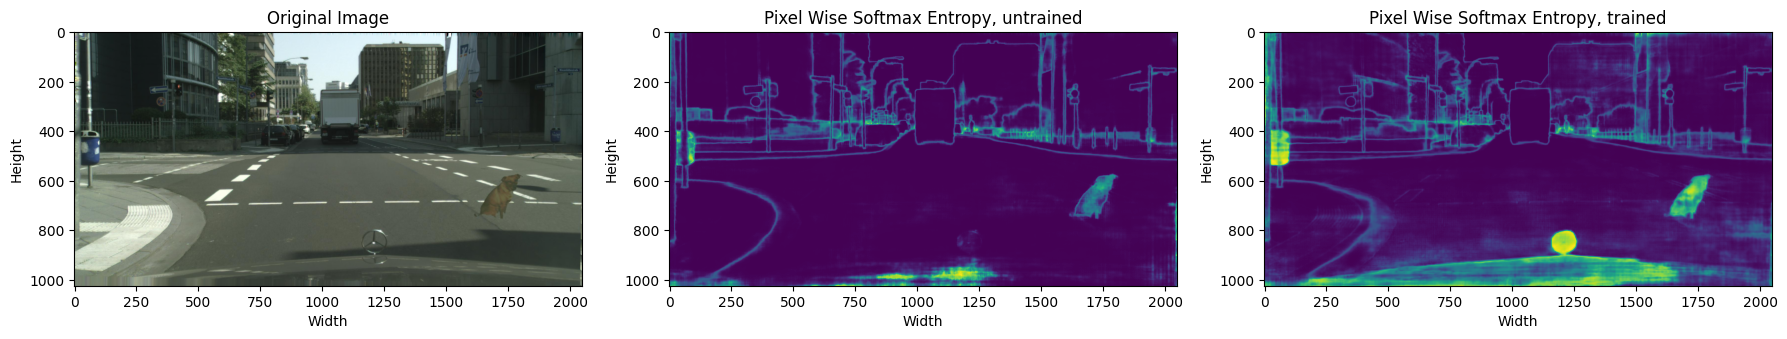

In [50]:

fig, axs = plt.subplots(1,3, figsize=(18, 12))

axs[0].imshow(np.clip(np.transpose(image_plot.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[0].set_title('Original Image')
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

axs[1].imshow(pixel_wise_softmax_entropy_train, cmap='viridis')
axs[1].set_title('Pixel Wise Softmax Entropy, untrained')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

axs[2].imshow(pixel_wise_softmax_entropy_train1, cmap='viridis')
axs[2].set_title('Pixel Wise Softmax Entropy, trained')
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Height')

plt.tight_layout()
plt.show()